# 課題5: 住宅価格の予測（Advanced Version）

課題3ではKaggleにある住宅価格予測を行いました。その際に利用したデータは、モデリングの基礎を学びやすくするために、変数の抜粋やデータの調整を施しました。

では、調整されていない「実際のデータ」を使って解析するには、どうしたらよいでしょうか？Kaggle MasterのSerigne氏が、その方法をKaggleのサイト内で公開しています。
https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

本課題では、上記のページに書かれている内容の中から重要な部分をピックアップし、<i>dataset/kaggle_housing_price.csv</i> のデータを使って作業に取り組んでもらいます。課題を通じて「実際のデータを使って解析する際にどのような作業を行うか」について学び、今までの知識をブラッシュアップしていきましょう。CSVの各列がどういう情報かについては、以下のページの Data fields を参照してください。
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

## 1. 必要なモジュールの読み込み

In [90]:
import numpy as np
import pandas as pd 
import scipy as sp
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.formula.api as smf
import statsmodels.api as sm

%matplotlib inline

## 2. データの読み込み

In [91]:
# データを読み込んで変数 data に格納
data = pd.read_csv('dataset/kaggle_housing_price.csv')

In [92]:
# データの最初の5行だけ表示
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 3. データ概要の確認

そもそもt検定などを実施する場合、データに正規性と等分散性があるのか否かが重要です。等分散性がないと結果を正しく解析することができません<sup>※1</sup>。

正規性が確認できない場合は、何らかの **データ変換** を行い、正規性が確保できる状態にします<sup>※2</sup>。


> ※1：等分散性を考慮しなくてもt検定が行えるものもあります。ウェルチの検定が一例です。 https://ja.wikipedia.org/wiki/%E3%82%A6%E3%82%A7%E3%83%AB%E3%83%81%E3%81%AEt%E6%A4%9C%E5%AE%9A

> ※2：ただし、あらゆるデータ変換の方法を試すのは、自分にとって都合の良い結果を探し回る行為（p値ハッキング）になりかねませんので、気をつけましょう。

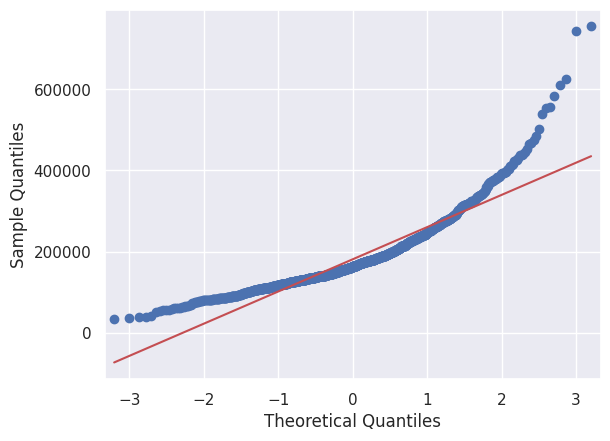

In [93]:
# SalePriceについて Q-Qプロットを表示して正規性を確認　
fig = sm.qqplot(data['SalePrice'], line = 's')

Q-Qプロットでデータの点が線上にきれいに乗っていれば、正規性は確認できます。もし、データの点が線から少し離れてしまっている（正規性が明確には確認できない）場合は、データ変換を試みます。今回は **対数変換** を行いましょう。

対数変換には、NumPyのlog1pを用いて、SalePriceの全てのデータの対数変換を実施します。NumPyの公式サイトに詳細が記載されています。<br>
https://docs.scipy.org/doc/numpy/reference/generated/numpy.log1p.html

また、対数変換を行う意味については、次のページなどで調べてみてください。<br>
https://atarimae.biz/archives/13161

In [94]:
#　NumPy の log1p を用いて全てのデータの対数変換を実施　
data['SalePrice'] = np.log1p(data['SalePrice'])

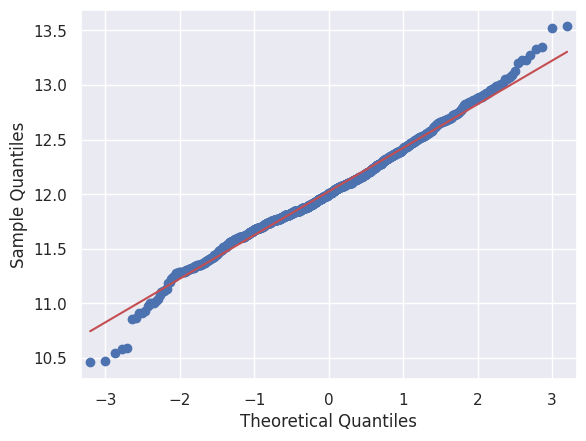

In [95]:
#　対数変換をした後のデータで再度Q-Qプロットを作成し、表示
fig = sm.qqplot(data['SalePrice'], line = 's')

対数変換しなかった場合よりも、データの点が線上にきれいに乗っているかと思います。これで正規性が確認できました。

## 4. 欠損値の確認と補充

データが欠損値を含む場合、そのまま回帰分析等を行うとエラーが発生したり、精度が悪くなる可能性があります。

欠損値があまり多くない場合には、シンプルに欠損値を含むデータを削除すればよいです。
しかし、欠損値が多い場合には削除してしまうとデータの多くを失ってしまうことになります。
そのような場合には、**当たり障りのない値で埋める** という手法が取られます。

*dataset/kaggle_housing_price.csv*では、欠損したデータには <code><span style="color: red; ">NA</span></code>という2文字が入っています。  
Pandasの<code><span style="color: red; ">read_csv</span></code>では 「<code><span style="color: red; ">NA</span></code>とだけ入っているデータは欠損値である」というルールでcsvを読み込んでくれます。  
　※ 欠損値は、ノートブックでは <code><span style="color: red; ">NaN</span></code>：Not a Numberと表示されます  

そのため、後は私たちの手で欠損値をどう扱うか決めて、何らかのデータで補充する処理を行います。  
セルのコメントに従って、欠損値の確認と補充を行ってみましょう。

In [96]:
# 欠損値の確認
# 1. dataの各列に含まれる欠損値の数を調べ、各列のデータ数に占める欠損値の割合を計算して、変数all_data_na に格納する
all_data_na = data.columns
for data_na in all_data_na:
    missing_na = sum(pd.isnull(data[data_na]))
    print(data_na, ': missing record number is', missing_na)

# 2. 変数all_data_naを表示する 　※本処理は変更不要
all_data_na


Id : missing record number is 0
MSSubClass : missing record number is 0
MSZoning : missing record number is 0
LotFrontage : missing record number is 259
LotArea : missing record number is 0
Street : missing record number is 0
Alley : missing record number is 1369
LotShape : missing record number is 0
LandContour : missing record number is 0
Utilities : missing record number is 0
LotConfig : missing record number is 0
LandSlope : missing record number is 0
Neighborhood : missing record number is 0
Condition1 : missing record number is 0
Condition2 : missing record number is 0
BldgType : missing record number is 0
HouseStyle : missing record number is 0
OverallQual : missing record number is 0
OverallCond : missing record number is 0
YearBuilt : missing record number is 0
YearRemodAdd : missing record number is 0
RoofStyle : missing record number is 0
RoofMatl : missing record number is 0
Exterior1st : missing record number is 0
Exterior2nd : missing record number is 0
MasVnrType : missi

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [97]:
# 欠損値が1つ以上ある列の情報のみを表示
# 1. 変数all_data_naをDataFrameに変換し、変数missing_data に格納する（この際、DataFrameの欠損値の割合の列名は'Missing_Ratio'にすること）
all_data_na = (data.isnull().sum() / len(data)) * 100
missing_data = pd.DataFrame({'Missing_Ratio' :all_data_na})

# 2. 欠損値が1つ以上ある列をqueryメソッドで抽出し、表示する
missing_data.query('Missing_Ratio > 0')

,Missing_Ratio
LotFrontage,17.739726
Alley,93.767123
MasVnrType,0.547945
MasVnrArea,0.547945
BsmtQual,2.534247
BsmtCond,2.534247
BsmtExposure,2.602740
BsmtFinType1,2.534247
BsmtFinType2,2.602740
Electrical,0.068493


次に、欠損値の補充を行います。本来なら全ての列について欠損値を埋めるべきですが、以下では2つの列についてのみ対応します。

### 4-1. PoolQCの場合

プールが無い家の PoolQC（プールの品質） の列に NaN（csv上では NA ） が入っています。ですので「無いことを意味しているが欠損値として扱われないデータ」、たとえば "None" という文字列、もしくは整数の 0 で置き換えましょう。

In [98]:
# PoolQCの欠損値を文字列 "None" で置換する
data['PoolQC'] = data['PoolQC'].fillna('None')

In [99]:
# PoolQCの欠損値が"None"で置換されたことを確認する
data['PoolQC'].head()

0    None
1    None
2    None
3    None
4    None
Name: PoolQC, dtype: object

### 4-2. LotFrontageの場合

LotFrontageは「間口の広さ（家屋の正面の幅）」です。LotFrontageが欠損している場合、どのような値を埋めれば良いでしょうか。一例としては「近隣の家々、つまり『近くの通りの名前（Neighborhood）』が同じ家々のLotFrontageの値とほぼ同じになる」という考え方です。そこで今回は、補充する値として「Neighborhoodが同じ家々のLotFrontageの中央値（median）」を採用します。

In [100]:
# LotFrontageの欠損値を、近隣の家（Neighborhood）単位でLotFrontageのmedianを取って、その値で埋める
data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [101]:
# LotFrontageの欠損値が近隣の家々のLotFrontageのmedianで置換されたことを確認
data['LotFrontage'].head()

0    65.0
1    80.0
2    68.0
3    60.0
4    84.0
Name: LotFrontage, dtype: float64

## 5. 変数の選択

テキストではあまり触れられていませんでしたが、相関関係のある変数を複数、モデルに含めてしまうと、回帰係数の分散が大きくなりモデルが不安定になります。この問題を **多重共線性** と言います。多重共線性を回避するためには、あらかじめ変数同士の相関について確認し、強い相関関係にあるものは取り除く必要があります。ここではその方法について確認しましょう。

その手法が、Kaggle内の以下のページにまとめられています。こちらの内容を参考にしながら、下記の作業に取り組んでください。<br>
https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection

In [102]:
threshold = 0.8    # 相関係数が threshold に設定した数値以上だった場合、その変数を取り除く

In [103]:
# data から相関行列（Correlation Matrix）を作成して表示する。その際、絶対値を適用して負の値をプラスに変換すること
corr_matrix = data.corr().abs()
corr_matrix.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,0.003381,0.033226,0.028365,0.012609,0.012713,0.021998,0.050298,0.005024,...,0.029643,0.000477,0.002889,0.046635,0.001330,0.057044,0.006242,0.021172,0.000712,0.017942
MSSubClass,0.011156,1.000000,0.370367,0.139781,0.032628,0.059316,0.027850,0.040581,0.022936,0.069836,...,0.012579,0.006100,0.012037,0.043825,0.026030,0.008283,0.007683,0.013585,0.021407,0.073959
LotFrontage,0.003381,0.370367,1.000000,0.335957,0.239546,0.043595,0.120999,0.084550,0.196825,0.232576,...,0.088736,0.141734,0.008057,0.064654,0.041063,0.174567,0.005332,0.007370,0.004756,0.353288
LotArea,0.033226,0.139781,0.335957,1.000000,0.105806,0.005636,0.014228,0.013788,0.104160,0.214103,...,0.171698,0.084774,0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,0.014261,0.257320
OverallQual,0.028365,0.032628,0.239546,0.105806,1.000000,0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,0.113937,0.030371,0.064886,0.065166,0.031406,0.070815,0.027347,0.817185


In [104]:
# 対角線上は絶対に 1 になること、および、対角線より下の部分は、上の部分と情報が重複していることから
# 相関行列を上三角行列に変換 
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,NaN,0.011156,0.003381,0.033226,0.028365,0.012609,0.012713,0.021998,0.050298,0.005024,...,0.029643,0.000477,0.002889,0.046635,0.001330,0.057044,0.006242,0.021172,0.000712,0.017942
MSSubClass,NaN,NaN,0.370367,0.139781,0.032628,0.059316,0.027850,0.040581,0.022936,0.069836,...,0.012579,0.006100,0.012037,0.043825,0.026030,0.008283,0.007683,0.013585,0.021407,0.073959
LotFrontage,NaN,NaN,NaN,0.335957,0.239546,0.043595,0.120999,0.084550,0.196825,0.232576,...,0.088736,0.141734,0.008057,0.064654,0.041063,0.174567,0.005332,0.007370,0.004756,0.353288
LotArea,NaN,NaN,NaN,NaN,0.105806,0.005636,0.014228,0.013788,0.104160,0.214103,...,0.171698,0.084774,0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,0.014261,0.257320
OverallQual,NaN,NaN,NaN,NaN,NaN,0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,0.113937,0.030371,0.064886,0.065166,0.031406,0.070815,0.027347,0.817185


In [105]:
# 上三角行列から SalePrice以外の列について threshold 以上の値が1つ以上ある列を抽出。その「削除すべき変数」の名前および総数を表示する
# （→これを除去すべき変数と判断します）
to_drop = [column for column in upper.columns if column != 'SalePrice' if any(upper[column] > threshold)]

print('削除すべき変数：', to_drop)
print('削除すべき変数の数：', len(to_drop))

削除すべき変数： ['1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea']
削除すべき変数の数： 4


In [106]:
# data から削除する変数を削除して data_dropped に格納し、data_dropped の内容を表示する
data_dropped = data.drop(columns = to_drop)
data_dropped.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,None,NaN,NaN,0,2,2008,WD,Normal,12.247699
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,None,NaN,NaN,0,5,2007,WD,Normal,12.109016
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,None,NaN,NaN,0,9,2008,WD,Normal,12.317171
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,None,NaN,NaN,0,2,2006,WD,Abnorml,11.849405
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,None,NaN,NaN,0,12,2008,WD,Normal,12.429220


## 6. ダミー変数化

カテゴリ変数は **ダミー変数化** する必要があります。

ひとつ例を出して説明します。たとえば、「Weather」という列があり、そこに入っているデータが、以下の3種類の文字列のみで構成されているとします。

- 'Sunny'（晴れ）
- 'Cloudy'（くもり）
- 'Rainy'（雨）

このとき「Weather」を、以下のような内容の3つの列に分割します。

- Weather_Sunny：元の Weather のデータが 'Sunny' なら整数値の 1 が、それ以外なら整数値の 0 が入る
- Weather_Cloudy：元の Weather のデータが 'Cloudy' なら整数値の 1 が、それ以外なら整数値の 0 が入る
- Weather_Rainy：元の Weather のデータが 'Rainy' なら整数値の 1 が、それ以外なら整数値の 0 が入る

このような作業がダミー変数化です。

In [107]:
# data_dropped に含まれる全てのカテゴリ変数をダミー変数化して data_dummied に格納する。ダミー変数化には Pandas の関数を実行すること。
# （ひとつずつダミー変数化しても良いですが、ここでは一気に全てダミー変数化する命令を使います）
data_dummied = pd.get_dummies(data_dropped)

In [108]:
# ダミー変数化されたことを確認
data_dummied.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,1,0,0,0,0,1,0


In [109]:
print(data.isnull().sum())

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 81, dtype: int64


ここまで、読み込んだデータに対して「データの対数変換」「欠損値の補充」「多重共線性の回避」「ダミー変数化」の作業を行いました。このような作業を通したデータを分類や予測にかけると、精度の良い結果が得られます。

本課題としての必須項目は、ここまでです。お疲れ様でした！

もし余裕がある場合は、以下の（任意）の内容について取り組みましょう。

## 7. （任意）住宅価格の予測の実行

せっかくなので、得られたデータを予測にかけてみましょう。

### 7-1. さらなる欠損値の補充

上記では、欠損値の補充を2種類（PoolQC と LotFrontage）しか行いませんでした。まずは、変数 data に対してさらなる欠損値の補充を行いましょう。

In [131]:
# https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
# 上記ページの内容を参考に、data に入っているデータのうち、
# 既に補充している PoolQC と LotFrontage 以外の列について、補充すべき欠損値を補充する
data["Alley"] = data["Alley"].fillna("None")
data["MasVnrType"] = data["MasVnrType"].fillna("None")
data["MasVnrArea"] = data["MasVnrArea"].fillna(0)

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    data[col] = data[col].fillna('None')
    
data['Electrical'] = data['Electrical'].fillna(data['Electrical'].mode()[0])

data["FireplaceQu"] = data["FireplaceQu"].fillna("None")

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    data[col] = data[col].fillna('None')
    
data["GarageYrBlt"] = data["GarageYrBlt"].fillna(0)

data["Fence"] = data["Fence"].fillna("None")
data["MiscFeature"] = data["MiscFeature"].fillna("None")

In [133]:
all_data_na = (data.isnull().sum() / len(data)) * 100
missing_data = pd.DataFrame({'Missing_Ratio' :all_data_na})

# 2. 欠損値が1つ以上ある列をqueryメソッドで抽出し、表示する
missing_data.query('Missing_Ratio > 0')

,Missing_Ratio


### 7-2. 変数の選択とダミー変数化を再度実施する

In [134]:
threshold = 0.8    # 相関係数が threshold に設定した数値以上だった場合、その変数を取り除く

In [135]:
# data から相関行列（Correlation Matrix）を作成する。その際、絶対値を適用して負の値をプラスに変換すること
corr_matrix = data.corr().abs()
corr_matrix.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,0.003381,0.033226,0.028365,0.012609,0.012713,0.021998,0.005024,0.005968,...,0.029643,0.000477,0.002889,0.046635,0.001330,0.057044,0.006242,0.021172,0.000712,0.017942
MSSubClass,0.011156,1.000000,0.370367,0.139781,0.032628,0.059316,0.027850,0.040581,0.069836,0.065649,...,0.012579,0.006100,0.012037,0.043825,0.026030,0.008283,0.007683,0.013585,0.021407,0.073959
LotFrontage,0.003381,0.370367,1.000000,0.335957,0.239546,0.043595,0.120999,0.084550,0.232576,0.052237,...,0.088736,0.141734,0.008057,0.064654,0.041063,0.174567,0.005332,0.007370,0.004756,0.353288
LotArea,0.033226,0.139781,0.335957,1.000000,0.105806,0.005636,0.014228,0.013788,0.214103,0.111170,...,0.171698,0.084774,0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,0.014261,0.257320
OverallQual,0.028365,0.032628,0.239546,0.105806,1.000000,0.091932,0.572323,0.550684,0.239666,0.059119,...,0.238923,0.308819,0.113937,0.030371,0.064886,0.065166,0.031406,0.070815,0.027347,0.817185


In [136]:
# 相関行列を上三角行列に変換 
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,NaN,0.011156,0.003381,0.033226,0.028365,0.012609,0.012713,0.021998,0.005024,0.005968,...,0.029643,0.000477,0.002889,0.046635,0.001330,0.057044,0.006242,0.021172,0.000712,0.017942
MSSubClass,NaN,NaN,0.370367,0.139781,0.032628,0.059316,0.027850,0.040581,0.069836,0.065649,...,0.012579,0.006100,0.012037,0.043825,0.026030,0.008283,0.007683,0.013585,0.021407,0.073959
LotFrontage,NaN,NaN,NaN,0.335957,0.239546,0.043595,0.120999,0.084550,0.232576,0.052237,...,0.088736,0.141734,0.008057,0.064654,0.041063,0.174567,0.005332,0.007370,0.004756,0.353288
LotArea,NaN,NaN,NaN,NaN,0.105806,0.005636,0.014228,0.013788,0.214103,0.111170,...,0.171698,0.084774,0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,0.014261,0.257320
OverallQual,NaN,NaN,NaN,NaN,NaN,0.091932,0.572323,0.550684,0.239666,0.059119,...,0.238923,0.308819,0.113937,0.030371,0.064886,0.065166,0.031406,0.070815,0.027347,0.817185


In [137]:
# 「削除すべき変数」の名前および総数を表示する
to_drop = [column for column in upper.columns if column != 'SalePrice' if any(upper[column] > threshold)]

print('削除すべき変数：', to_drop)
print('削除すべき変数の数：', len(to_drop))

削除すべき変数： ['1stFlrSF', 'TotRmsAbvGrd', 'GarageArea']
削除すべき変数の数： 3


In [138]:
# data から削除する変数を削除して data_dropped に格納し、data_dropped の内容を表示する
data_dropped = data.drop(columns = to_drop)
data_dropped.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,None,NaN,NaN,0,2,2008,WD,Normal,12.247699
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,None,NaN,NaN,0,5,2007,WD,Normal,12.109016
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,None,NaN,NaN,0,9,2008,WD,Normal,12.317171
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,None,NaN,NaN,0,2,2006,WD,Abnorml,11.849405
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,None,NaN,NaN,0,12,2008,WD,Normal,12.429220


In [139]:
# data_dropped に含まれる全てのカテゴリ変数をダミー変数化して data_dummied に格納し、表示
data_dummied = pd.get_dummies(data_dropped)
data_dummied.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,706,0,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,978,0,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,486,0,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,216,0,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,655,0,...,0,0,0,1,0,0,0,0,1,0


### 7-3. データを訓練データとテストデータに分割

In [140]:
from sklearn.model_selection import train_test_split    # 必要なモジュールの読み込み

In [141]:
# 説明変数 X を用意する。ただし Id列, SalePrice列は除去する
X = data_dummied.drop(columns = ['Id', 'SalePrice'])

In [142]:
# 応答変数 y は SalePrice 列だけのデータで用意する
y = data_dummied['SalePrice']

In [143]:
# X、y を訓練データ (X_train, y_train) とテストデータ (X_test, y_test) に分ける
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [144]:
y_train

64      12.299112
682     12.061053
960     11.665655
1384    11.561725
1100    11.002117
          ...    
763     12.727841
835     11.759793
1216    11.626263
559     12.363081
684     12.305923
Name: SalePrice, Length: 1022, dtype: float64

### 7-4. 重回帰分析

In [145]:
# 必要なモジュールの読み込み  
from sklearn.linear_model import RidgeCV  
from sklearn.metrics import mean_squared_error

In [146]:
# Ridge回帰モデルを作成して予測を実行する
# 1. lambdaを50個つくる
n_lambda = 50
ridge_lambdas = np.logspace(-10, 1, n_lambda)
# 2. RidgeCVを使って最適なlambdaでモデルを構築する
model = RidgeCV(cv=10, alphas=ridge_lambdas, fit_intercept=False)
#3. 訓練データを指定してモデルを推定する
#（推定の際、Warningが発生することがあります。Errorという表記が無ければ無視して頂いて大丈夫です）
#print(X_train.shape)
#print(y_train.shape)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(mean_squared_error(y_test,y_pred))

/home/ubuntu/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.22278e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/ubuntu/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.90503e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/ubuntu/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.81077e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/ubuntu/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.14443e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/ubuntu/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/linear_model/

0.02870435793050211


In [149]:
# 訓練データに対する決定係数を表示
model.score(X_train, y_train)

0.9419958568208526

In [150]:
# テストデータに対する決定係数を表示
model.score(X_test, y_test)

0.8142224516333922

データの件数を増やすなど工夫の余地はありますが、まずまずの的中率を得られたのではないでしょうか。